# Whole-Brain Models, Part 3: Whole brain models + redundancy + synergy


We employ the **Modified Jansen & Rit neural mass model** proposed by *Coronel-Oliveros et al. (2024)* [1] to investigate the emergence of informational interactions across brain regions in **healthy subjects**. Our focus is on analyzing how **redundancy** and **synergy** [2-3] evolve under two distinct conditions:

1. **Increasing the global coupling parameter** (`K`).
2. **Increasing the noise amplitude** (`σ`).

These simulations allow us to explore how different dynamical regimes affect redundancy and synergy.

**Note**: We will use the HOI package for computing redundancy and synergy.
A gentle introduction to the theoretical background and usage of the package will be provided in the afternoon session.

[1] Coronel‐Oliveros, C., Gómez, R. G., Ranasinghe, K., Sainz‐Ballesteros, A., 
Legaz, A., Fittipaldi, S., ... & Ibañez, A. (2024). Viscous dynamics associated 
with hypoexcitation and structural disintegration in neurodegeneration via 
generative whole‐brain modeling. Alzheimer's & Dementia

[2] Pedro A.M. Mediano, Fernando E. Rosas, Andrea I Luppi, Robin L. Carhart-Harris, Daniel Bor, Anil K. Seth, Adam B. Barrett. 	arXiv:2109.13186. Towards an extended taxonomy of information dynamics via Integrated Information Decomposition. 

[3] Luppi, A.I., Mediano, P.A.M., Rosas, F.E. et al. A synergistic core for human brain evolution and cognition. Nat Neurosci 25, 771–782 (2022). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal
import JansenRitModelMulti as JR

import hoi
## Some brain plots
from nilearn import datasets, surface, plotting
import nibabel as nib

In [2]:
####### Auxiliary function: Converts a vector representing the upper triangle (excluding the diagonal) of a symmetric n x n matrix into the full matrix (nxn)
def vector_to_symmetric_matrix(vec, n):
    """
    Converts a vector representing the upper triangle (excluding the diagonal)
    of a symmetric n x n matrix into the full symmetric matrix.

    Parameters:
    -----------
    vec : array-like
        Vector of length n*(n-1)/2 containing the upper triangle values (excluding the diagonal).
    n : int
        Size of the resulting square matrix.

    Returns:
    --------
    mat : np.ndarray
        Symmetric matrix of shape (n, n)
    """
    vec = np.asarray(vec).flatten()
    expected_len = n * (n - 1) // 2
    if len(vec) != expected_len:
        raise ValueError(f"Vector length {len(vec)} does not match expected size {expected_len} for n={n}.")
    mat = np.zeros((n, n))
    triu_indices = np.triu_indices(n, k=1)
    mat[triu_indices] = vec
    mat = mat + mat.T
    return mat

## How Redundancy and Synergy change with global coupling

As a reference, we will include the **functional connectivity (FC)** matrix previously computed in the earlier tutorial.  


In [3]:
#Simulations parameters
rois = 82

#Simulations parameters
JR.tmax = 60#120 #max sim time 
JR.teq = 20 #eq time for reaching steady-state dynamics
JR.dt = 0.001 #integration step
JR.downsamp = 20 #downsampling for reducing memory consumption

#networks parameters
JR.M = np.load('SC_HCs.npy') #SC matrix
JR.nnodes = len(JR.M) #number of nodes
JR.norm = 1 #normalization factor

#Noise an inputs
JR.sigma = 1 #noise scaling factor
JR.p = 220 * np.ones(JR.nnodes) #inputs for individual nodes

#Plasticity
JR.plasticity_on = 1 #1: activated, 0: disabled
JR.target = 2.5 * np.ones(JR.nnodes) #target firing rate in Hz
JR.tau_p = 2 #time constant for plasticity (in seconds)


#Proportion of alpha neurons
JR.alpha = 0.5 * np.ones(JR.nnodes)
JR.gamma = 1 - JR.alpha

#updating some parameters
JR.update() #avoid this in extensive simulations (call it increases memory consumption).
            #just use it one time before parallelization

###HERE WE ARE CHANGING THE GLOBAL COUPLING PARAMETER
K_vec = [0, 0.3, 0.5]#coupling values
FCs = np.zeros((82,82,3)) #for storing FC matrices
mean_corrs = np.zeros(3) #mean_corrs = mean values of FC matrices

Reds = np.zeros((82,82,3)) #for storing redundancy matrices
Syns = np.zeros((82,82,3)) #for storing synergy matrices


for i in range(3):
    print(i)
    #######We will modify the global coupling
    JR.K = K_vec[i] #Global Coupling

    #Simulation starts here
    y, t = JR.Sim(verbose = False)
    #Simulations end here

    #EEG-like signals
    EEG = (JR.alpha * y[:,1,:] + JR.gamma * y[:,7,:]) - (JR.alpha * y[:,2,:] + JR.gamma * y[:,8,:])

    #filtering and computing FC
    fmin, fmax = 8, 13
    a0,b0 = signal.bessel(3, 2 * JR.dt * JR.downsamp * np.array([fmin, fmax]), btype = 'bandpass')

    Vfilt = signal.filtfilt(a0, b0, EEG, 0) #filtered signals
    FC = np.corrcoef(Vfilt.T) #Functional connectivity
    FCs[:,:,i] = FC.copy() #storing
    mean_corrs[i] = np.mean(FC) #more storing...
    np.shape(Vfilt)

    ############ To compute redundancy and synergy
    #For the redundancy
    model_red = hoi.metrics.RedundancyphiID(Vfilt)#(time points, number of regions)
    result_red = model_red.fit(minsize=2, maxsize=2);
    Reds[:,:,i] = vector_to_symmetric_matrix(result_red,rois)
    del model_red

    #For the synergy
    model_syn = hoi.metrics.SynergyphiID(Vfilt)#(time points, number of regions)
    result_syn = model_syn.fit(minsize = 2, maxsize=2)
    Syns[:,:,i] = vector_to_symmetric_matrix(result_syn,rois)
    del model_syn
    #break
    

0


    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

1


    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

2


    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

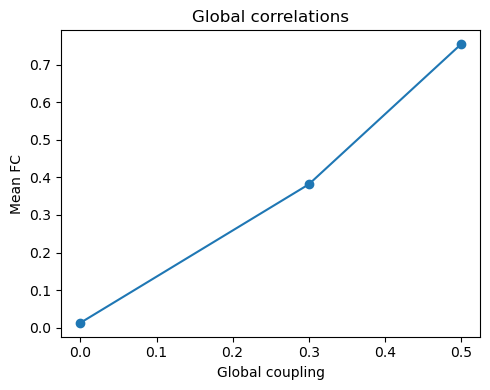

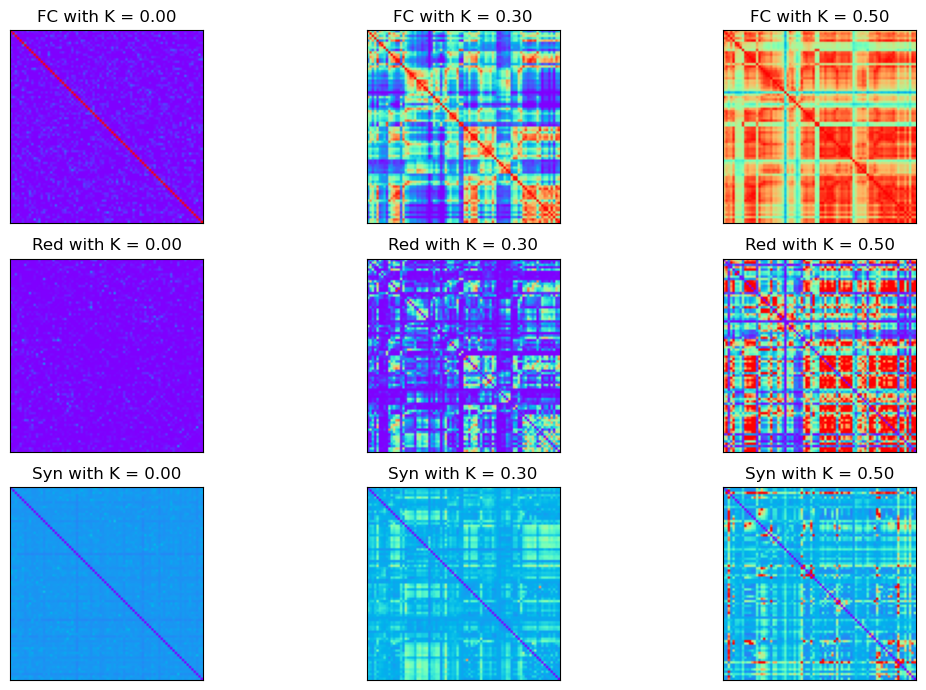

In [4]:
#some plots

plt.figure(1, figsize = (5,4))
plt.clf()

plt.plot(K_vec, mean_corrs,'-o')
plt.xlabel('Global coupling')
plt.ylabel('Mean FC')
plt.title('Global correlations')

plt.tight_layout()

plt.figure(2, figsize = (12,7))
plt.clf()

idplot = 1;
for i in range(0, len(K_vec)):
    plt.subplot(3,len(K_vec),idplot)
    plt.imshow(FCs[:,:,i], vmin = 0, vmax = 1, cmap = 'rainbow')
    plt.xticks([])
    plt.yticks([])
    plt.title('FC with K = %.2f'%K_vec[i])
    idplot = idplot+1

for i in range(0, len(K_vec)):
    plt.subplot(3,len(K_vec),idplot)
    plt.imshow(Reds[:,:,i], vmin = 0, vmax = 0.08, cmap = 'rainbow')
    plt.xticks([])
    plt.yticks([])
    plt.title('Red with K = %.2f'%K_vec[i])
    idplot = idplot+1

for i in range(0, len(K_vec)):
    plt.subplot(3,len(K_vec),idplot)
    plt.imshow(Syns[:,:,i], vmin = 0, vmax = 0.25, cmap = 'rainbow')
    plt.xticks([])
    plt.yticks([])
    plt.title('Syn with K = %.2f'%K_vec[i])
    idplot = idplot+1
plt.tight_layout()


## How FC, Redundancy and Synergy changes with Noise

In [5]:
JR.K = 0.3 

# Noise scaling values
noise_vec = [0.5,4,10]

# Storage for results
FCs_noise = np.zeros((rois, rois, len(noise_vec)))
mean_corrs_noise = np.zeros(len(noise_vec))
Reds_noise = np.zeros((rois, rois, len(noise_vec)))
Syns_noise = np.zeros((rois, rois, len(noise_vec)))

for i in range(len(noise_vec)):
    print(f"Running simulation with noise level: {noise_vec[i]}")
    
    JR.sigma = noise_vec[i]  # Set noise level

    # Run simulation
    y, t = JR.Sim(verbose=False)

    # EEG-like signal
    EEG = (JR.alpha * y[:,1,:] + JR.gamma * y[:,7,:]) - (JR.alpha * y[:,2,:] + JR.gamma * y[:,8,:])

    # Bandpass filter (8–13 Hz)
    fmin, fmax = 8, 13
    a0, b0 = signal.bessel(3, 2 * JR.dt * JR.downsamp * np.array([fmin, fmax]), btype='bandpass')
    Vfilt = signal.filtfilt(a0, b0, EEG, axis=0)

    # Functional connectivity
    FC = np.corrcoef(Vfilt.T)
    FCs_noise[:, :, i] = FC.copy()
    mean_corrs_noise[i] = np.mean(FC)
    #break

    # Redundancy
    model_red = hoi.metrics.RedundancyphiID(Vfilt)
    result_red = model_red.fit(minsize=2, maxsize=2)
    Reds_noise[:, :, i] = vector_to_symmetric_matrix(result_red, rois)
    del model_red

    # Synergy
    model_syn = hoi.metrics.SynergyphiID(Vfilt)
    result_syn = model_syn.fit(minsize=2, maxsize=2)
    Syns_noise[:, :, i] = vector_to_symmetric_matrix(result_syn, rois)
    del model_syn
    #break

Running simulation with noise level: 0.5


    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Running simulation with noise level: 4


    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

Running simulation with noise level: 10


    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

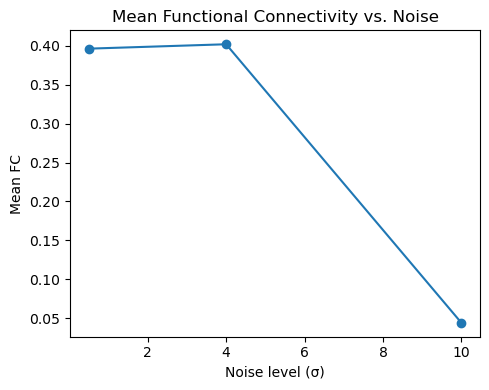

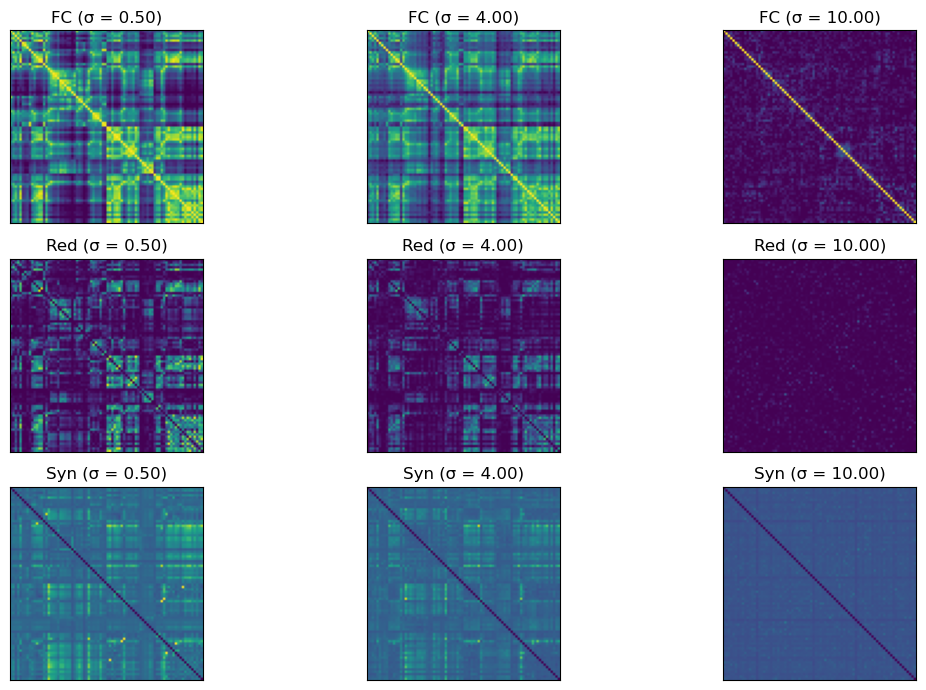

In [6]:
# --- Plot: Mean FC vs. Noise Level ---
plt.figure(1, figsize=(5, 4))
plt.clf()

plt.plot(noise_vec, mean_corrs_noise, '-o')
plt.xlabel('Noise level (σ)')
plt.ylabel('Mean FC')
plt.title('Mean Functional Connectivity vs. Noise')

plt.tight_layout()

# --- Plot: FC, Redundancy, and Synergy for each noise level ---
plt.figure(2, figsize=(12, 7))
plt.clf()

idplot = 1
for i in range(len(noise_vec)):
    plt.subplot(3, len(noise_vec), idplot)
    plt.imshow(FCs_noise[:, :, i], vmin=0, vmax=1)
    plt.xticks([]); plt.yticks([])
    plt.title('FC (σ = %.2f)' % noise_vec[i])
    idplot += 1

for i in range(len(noise_vec)):
    plt.subplot(3, len(noise_vec), idplot)
    plt.imshow(Reds_noise[:, :, i], vmin=0, vmax=0.08)
    plt.xticks([]); plt.yticks([])
    plt.title('Red (σ = %.2f)' % noise_vec[i])
    idplot += 1

for i in range(len(noise_vec)):
    plt.subplot(3, len(noise_vec), idplot)
    plt.imshow(Syns_noise[:, :, i], vmin=0, vmax=0.18)
    plt.xticks([]); plt.yticks([])
    plt.title('Syn (σ = %.2f)' % noise_vec[i])
    idplot += 1

plt.tight_layout()
plt.show()

## Redundancy and Synergy at the Optimal FC Heterogeneous Setting

The values of bias and scale will be chosen according to the configuration that best reproduces the empirical functional connectivity, computed in the previous tutorial.


In [7]:
# Best global coupling value for HCs
K_HCs = 0.3
# Select single bias and scale values
bias_value = 2.6
scale_value = -0.1

# Set model parameters
JR.K = K_HCs                          # Global coupling
JR.seed = 1                          # Random seed for reproducibility
JR.sigma = 2.5 

# Set heterogeneous E/I balance target using WM modulation
GMV_HCs = np.load('GMV_HCs.npy') #White matter volumes
GMV_HCs = np.delete(GMV_HCs, np.arange(70,78,1))

JR.target = (bias_value + scale_value * GMV_HCs) * np.ones(JR.nnodes)

# Run simulation
y, t = JR.Sim(verbose=False)

# Compute EEG-like signal
EEG = (JR.alpha * y[:,1,:] + JR.gamma * y[:,7,:]) - (JR.alpha * y[:,2,:] + JR.gamma * y[:,8,:])

# Bandpass filter (8–13 Hz)
fmin, fmax = 8, 13
a0, b0 = signal.bessel(3, 2 * JR.dt * JR.downsamp * np.array([fmin, fmax]), btype='bandpass')
Vfilt = signal.filtfilt(a0, b0, EEG, axis=0)

# Compute FC
FC_heterogeneous = np.corrcoef(Vfilt.T)

model_red = hoi.metrics.RedundancyphiID(Vfilt)
result_red = model_red.fit(minsize=2, maxsize=2)
Reds_heterogeneous = vector_to_symmetric_matrix(result_red, rois)

# Synergy
model_syn = hoi.metrics.SynergyphiID(Vfilt)
result_syn = model_syn.fit(minsize=2, maxsize=2)
Syns_heterogeneous = vector_to_symmetric_matrix(result_syn, rois)


    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/1 [00:00<?,       ?it/s]

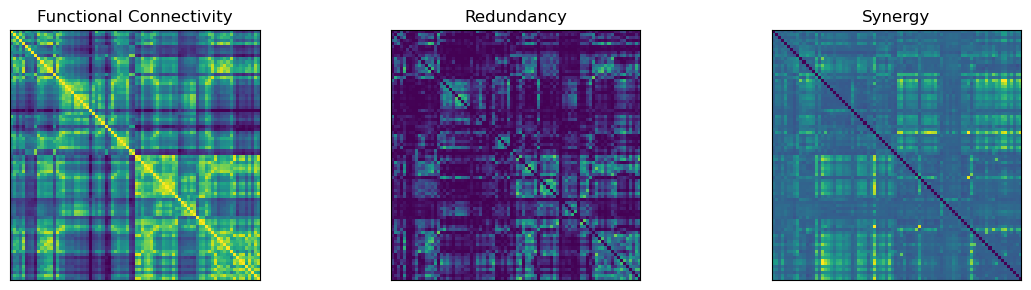

In [8]:
# Plot FC, Redundancy, and Synergy (heterogeneous case)
plt.figure(figsize=(12, 3))
plt.clf()

# Functional Connectivity
plt.subplot(1, 3, 1)
plt.imshow(FC_heterogeneous, vmin=0, vmax=1)
plt.title('Functional Connectivity')
plt.xticks([]); plt.yticks([])

# Redundancy
plt.subplot(1, 3, 2)
plt.imshow(Reds_heterogeneous, vmin=0, vmax=0.08)
plt.title('Redundancy')
plt.xticks([]); plt.yticks([])

# Synergy
plt.subplot(1, 3, 3)
plt.imshow(Syns_heterogeneous, vmin=0, vmax=0.18)
plt.title('Synergy')
plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()

**Note:** We observe that, when fitting the model to FC, redundancy and synergy typically fall within a sweet spot, avoiding the extreme regimes where both break down.
However, a key challenge is whether models can be improved by fitting redundancy and synergy rather than only FC.

### Redundancy and Synergy Differences Between Alzheimer's Disease and Healthy Controls

Finally, we will load the previously computed redundancy and synergy values for individuals with Alzheimer's disease (AD) and healthy controls (HC) and visualize the distribution of these measures across the two groups.

In [9]:
## Loading Redundancy values, per healthy control and Alzheimer disease
Red_hc = np.load('results_tutorial3/Red_hc.npy')
Red_ad = np.load('results_tutorial3/Red_ad.npy')

## Loading Synergy values 
Syn_ad = np.load('results_tutorial3/Syn_ad.npy')
Syn_hc = np.load('results_tutorial3/Syn_hc.npy')

## Loading FC values 
Fc_hc = np.load('results_tutorial3/Fc_hc.npy')
Fc_ad = np.load('results_tutorial3/Fc_ad.npy')


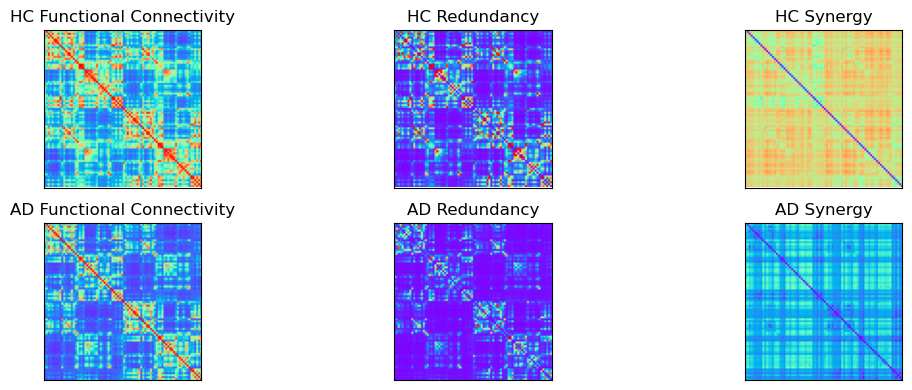

In [10]:
# Compute mean matrices per group

# Generate reordering index: first all lefts (even indices), then all rights (odd indices)
left_indices = np.arange(0, 82, 2)   # L1, L2, ..., L41 → indices 0, 2, 4, ...
right_indices = np.arange(1, 82, 2)  # R1, R2, ..., R41 → indices 1, 3, 5, ...
new_order = np.concatenate([left_indices, right_indices])

# Apply reordering for consistency
Fc_hc_mean = np.mean(np.abs(Fc_hc), axis=0)
Fc_ad_mean = np.mean(np.abs(Fc_ad), axis=0)

Red_hc_mean = np.mean(Red_hc, axis=0)
Red_ad_mean = np.mean(Red_ad, axis=0)

Syn_hc_mean = np.mean(Syn_hc, axis=0)
Syn_ad_mean = np.mean(Syn_ad, axis=0)


# Set up figure
plt.figure(figsize=(12, 4))
plt.clf()

# Plot FC
plt.subplot(2, 3, 1)
plt.imshow(Fc_hc_mean[new_order, :][:, new_order], vmin=0, vmax=1, cmap='rainbow')
plt.title('HC Functional Connectivity')
plt.xticks([]); plt.yticks([])

plt.subplot(2, 3, 4)
plt.imshow(Fc_ad_mean[new_order, :][:, new_order], vmin=0, vmax=1, cmap='rainbow')
plt.title('AD Functional Connectivity')
plt.xticks([]); plt.yticks([])

# Plot Redundancy
plt.subplot(2, 3, 2)
plt.imshow(Red_hc_mean[new_order, :][:, new_order], vmin=0, vmax=1, cmap='rainbow')
plt.title('HC Redundancy')
plt.xticks([]); plt.yticks([])

plt.subplot(2, 3, 5)
plt.imshow(Red_ad_mean[new_order, :][:, new_order], vmin=0, vmax=1, cmap='rainbow')
plt.title('AD Redundancy')
plt.xticks([]); plt.yticks([])

# Plot Synergy
plt.subplot(2, 3, 3)
plt.imshow(Syn_hc_mean[new_order, :][:, new_order], vmin=1, vmax=2.3, cmap='rainbow')
plt.title('HC Synergy')
plt.xticks([]); plt.yticks([])

plt.subplot(2, 3, 6)
plt.imshow(Syn_ad_mean[new_order, :][:, new_order], vmin=1, vmax=2.3, cmap='rainbow')
plt.title('AD Synergy')
plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()

C:\Users\mgatica\AppData\Local\Temp\ipykernel_17912\3069939705.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set3').colors


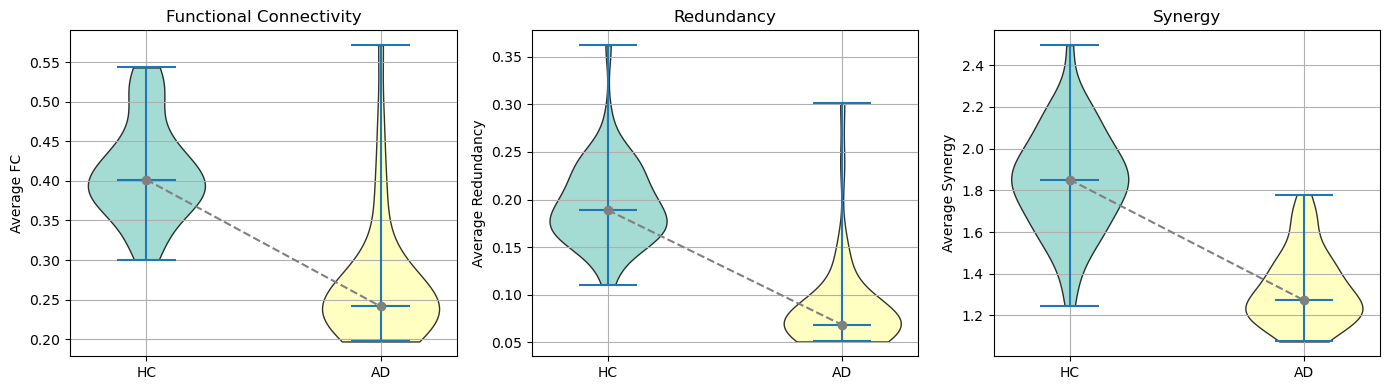

In [11]:

# Compute subject-level averages by collapsing over the 82x82 matrices
# For FC, take the absolute value before averaging
Fc_hc_flat = np.abs(Fc_hc).mean(axis=(1, 2))
Fc_ad_flat = np.abs(Fc_ad).mean(axis=(1, 2))
Red_hc_flat = Red_hc.mean(axis=(1, 2))
Red_ad_flat = Red_ad.mean(axis=(1, 2))
Syn_hc_flat = Syn_hc.mean(axis=(1, 2))
Syn_ad_flat = Syn_ad.mean(axis=(1, 2))

# Use pastel colors from the Set3 colormap
colors = cm.get_cmap('Set3').colors
hc_color = colors[0]   # teal for healthy controls
ad_color = colors[1]   # yellow for Alzheimer's group

# Create figure with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=False, sharey=False)

# Group data and labels for iteration
data_pairs = [
    (Fc_hc_flat, Fc_ad_flat, 'Functional Connectivity', 'Average FC'),
    (Red_hc_flat, Red_ad_flat, 'Redundancy', 'Average Redundancy'),
    (Syn_hc_flat, Syn_ad_flat, 'Synergy', 'Average Synergy')
]

# Plot each violin and connect medians
for ax, (hc, ad, title, ylabel) in zip(axs, data_pairs):
    # Create violin plot
    parts = ax.violinplot([hc, ad], showmedians=True, showextrema=True)

    # Color the violins using HC and AD group colors
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(hc_color if i == 0 else ad_color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.8)

    # Compute and connect medians
    median_hc = np.median(hc)
    median_ad = np.median(ad)
    ax.plot([1, 2], [median_hc, median_ad],
            color='gray', linestyle='--', marker='o', markersize=6, label='Median')

    # Axis and aesthetics
    ax.set_title(title)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['HC', 'AD'])
    ax.set_ylabel(ylabel)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# --- Step 1: Average only over the last axis, we'll obtain one vector (rois) per subject---
# For the FC
Fc_hc_flat = np.abs(Fc_hc).mean(axis=-1)    # shape: (N_HC, rois)
Fc_ad_flat = np.abs(Fc_ad).mean(axis=-1)    # shape: (N_AD, rois)
# Redundancy
Red_hc_flat = Red_hc.mean(axis=-1)
Red_ad_flat = Red_ad.mean(axis=-1)
# Synergy
Syn_hc_flat = Syn_hc.mean(axis=-1)
Syn_ad_flat = Syn_ad.mean(axis=-1)

from scipy.stats import ttest_ind

# --- Step 2: Function to compute Cohen's d effect size for each ROI ---
def cohen_d(group1, group2):
    mean_diff = group1.mean(axis=0) - group2.mean(axis=0)
    pooled_std = np.sqrt(((group1.std(axis=0, ddof=1) ** 2) +
                          (group2.std(axis=0, ddof=1) ** 2)) / 2)
    return mean_diff / pooled_std
    
## We would like to compare two groups (patients vs. controls)
# --- Step 3: Compute effect size for each measure ---
effect_size_fc = cohen_d(Fc_ad_flat, Fc_hc_flat)
effect_size_red = cohen_d(Red_ad_flat, Red_hc_flat)
effect_size_syn = cohen_d(Syn_ad_flat, Syn_hc_flat)

In [13]:

parcel_nii = nib.load('AAL.nii')
parcel_data = parcel_nii.get_fdata()

# === Extract all ROI labels (excluding background 0) ===
all_labels = np.unique(parcel_data)
all_labels = all_labels[all_labels != 0]  # Remove background
print(f"Total AAL ROIs: {len(all_labels)}")

# === Define the 82 ROIs you're using (labels, not indices) ===
# ROIs 0–89 excluding 70–77 → need to map to actual label values
full_roi_indices = np.array([i for i in range(90) if i < 70 or i > 77])
used_roi_labels = all_labels[full_roi_indices]  # These are the actual AAL label values for those ROIs

########Auxiliary function to show the effect sizes in a brain
# === Create brain map ===
def visualize_brain(parcel_data,effect_size_quantity,quantity_name):
    roi_img_data = np.zeros_like(parcel_data)
    
    for i, label in enumerate(used_roi_labels):
        mask = parcel_data == label
        roi_img_data[mask] = effect_size_quantity[i]
    
    # === Save map ===
    new_img = nib.Nifti1Image(roi_img_data, affine=parcel_nii.affine)
    
    
    # Load fsaverage for surface plotting
    fsaverage = datasets.fetch_surf_fsaverage()
    
    # Project volume to surface (e.g., to left hemisphere)
    texture = surface.vol_to_surf(new_img, fsaverage.pial_left)
    
    # Plot the statistical map on the inflated surface
    plotting.plot_surf_stat_map(
        surf_mesh=fsaverage.infl_left,
        stat_map=texture,
        hemi='left',
        title='%s (ADs - HCs) (Left Hemisphere)'%quantity_name,
        colorbar=True,
        cmap='jet_r',
        threshold=-0.4,
        vmax=-0.5,
        vmin=-2.5,
        bg_map=fsaverage.sulc_left
    )
    
    plotting.show()

Total AAL ROIs: 116


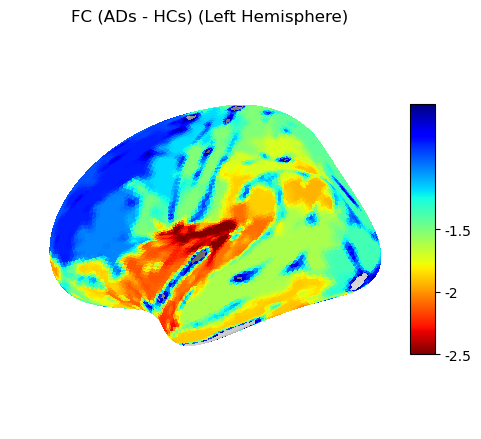

In [14]:
#### Functional connectivity
visualize_brain(parcel_data,effect_size_fc,"FC")

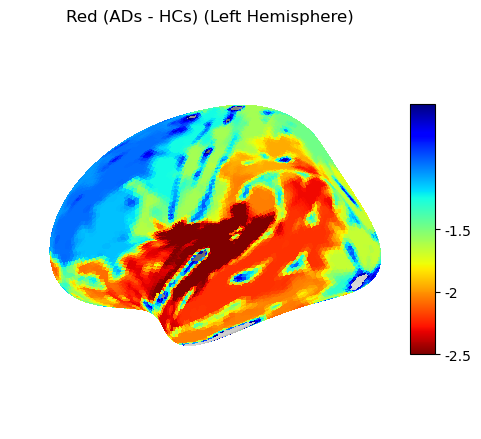

In [15]:
#### Redundancy
visualize_brain(parcel_data,effect_size_red,"Red")

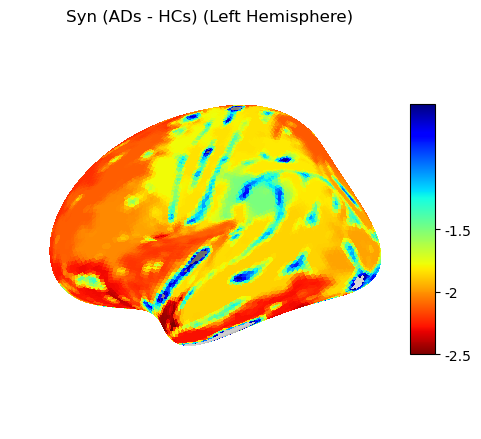

In [16]:
### Synergy
visualize_brain(parcel_data,effect_size_syn,"Syn")